## CCLE

## Description

This CCLE dataset is made by performing the usual bulk RNA-seq technique, then normalizing using RPKM (Reads Per Kilobase of transcript per Million) to reduce variance and make samples comparable.

The RPKM normalization solves two problems created during sequencing:

1. **Sequencing depth**, which happens when samples are sequenced to different depths. Some samples may have more or fewer total reads, but that difference does not reflect biology, so we correct for it.  
2. **Gene length**, because longer genes generate more reads just by being longer, and shorter genes fewer reads. Normalizing by gene length accounts for that.

The normalized (i, j) RPKM value, where (i) is a gene and (j) is a sample, is:

$$
\mathrm{RPKM}_{i,j}
=
\frac{x_{i,j}}{\,l_i \cdot \sum_k x_{k,j}\,}
\times 10^6
$$

<!-- blank line above is important -->
- **$x_{i,j}$** is the raw read count for gene \(i\) in sample \(j).  
- **$l_i$** is the length of gene \(i\) in kilobases (kb).  
- **$\sum_{k} x_{k,j}$** is the total number of reads in sample \(j\).  

In [12]:
import pandas as pd
import numpy as np

# mRNA seq
# Expression Data with gene as index and cells/samples as columns
data_mrna_seq_rpkm = pd.read_csv('ccle_data/data_mrna_seq_rpkm.txt',
                    sep = '\t',
                    comment = '#')

data_mrna_seq_rpkm.set_index('Hugo_Symbol',inplace=True)

# Merge with mean duplicated rows
data_mrna_seq_rpkm = data_mrna_seq_rpkm.groupby(data_mrna_seq_rpkm.index).mean()

In [13]:
data_mrna_seq_rpkm.head()

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
CRIPTOP1,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
7SK,0.029785,0.03377,0.047608,0.02094,0.00430,0.017847,0.006893,0.00704,0.008042,0.148955,...,0.083175,0.02683,0.002032,0.024993,0.094365,0.393628,0.035012,0.002465,0.05875,0.067953
A1BG,0.362300,0.00608,0.115170,0.33737,3.06452,0.013390,2.180160,2.24186,0.095400,3.698050,...,0.012700,0.09324,0.011340,0.060090,0.026380,0.019230,0.505580,0.578600,0.71115,0.849120
A1BG-AS1,4.815880,0.18959,0.751510,1.32578,9.15532,0.064590,1.619220,4.48351,0.631410,6.483210,...,0.371360,0.52954,0.187460,0.121010,0.359240,0.809130,2.750650,2.918060,2.06849,2.596400
A1CF,5.654860,2.55482,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,4.12239,0.000000,0.000000,0.000000,0.000000,0.000000,0.011540,0.00589,0.000000


In [14]:
#--------Mut query----------
# Description:
# Data telling  which sample is mutated and not-mutated
mutations= pd.read_csv('ccle_data/mutations.txt',
                    sep = '\t',
                    comment = '#')
mutations.set_index('SAMPLE_ID',inplace=True)

In [15]:
mutations.head()

,STUDY_ID,TP53
SAMPLE_ID,,
SJRH30_SOFT_TISSUE,ccle_broad_2019,R280S R273C Y205C
FADU_UPPER_AERODIGESTIVE_TRACT,ccle_broad_2019,R248L X225_splice
HH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ccle_broad_2019,X187_splice
SKNMC_BONE,ccle_broad_2019,WT
SNU182_LIVER,ccle_broad_2019,S215I


## Why predict on just the five Variant_Type classes

We focus on SNP, DNP, ONP, INS, and DEL because:

1. Biological clarity: these five labels describe the fundamental mutation mechanism, single-base or multi-base changes, insertions, and deletions, so the model learns clear patterns.  
2. Balanced data: each Variant_Type occurs often enough to give the model enough examples, while the detailed Variant_Classification labels are very uneven and would leave some classes too small to learn.  
3. Reduced complexity: Variant_Classification depends on gene structure and reading frame (for example a SNP can be silent or missense depending on codon), which our sequence‐only model cannot infer without extra annotation.  
4. Modular workflow: once the model tags a variant as INS or DEL, we can apply separate rules or a second model to predict functional impact, keeping each step simpler and more reliable.  


In [16]:
# ------Mut ALL-----------
# Dataset containing mutation classes for all genes, it only contains mutated samples
data_mutations = pd.read_csv('ccle_data/data_mutations.txt',
                    sep = '\t',
                    comment = '#')

# Extract TP53 from all genes
data_mutations = data_mutations[data_mutations['Hugo_Symbol'] == 'TP53']

/var/folders/xz/cl0qfkz56dl2q1b8vhqj2v180000gn/T/ipykernel_3267/449069273.py:3: DtypeWarning: Columns (4,51,53,54,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data_mutations = pd.read_csv('ccle_data/data_mutations.txt',


In [17]:
data_mutations.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,RNAseq_AC,SangerRecalibWES_AC,SangerWES_AC,TCGAhsCnt,WES_AC,WGS_AC,cDNA_Change,isCOSMIChotspot,isDeleterious,isTCGAhotspot
1782,TP53,7157,NaN,GRCh37,17,7576854,7576854,+,"missense_variant,splice_region_variant",Missense_Mutation,...,88:33,23:50,24:52,0,30:33,18:15,c.992A>G,True,True,False
3947,TP53,7157,NaN,GRCh37,17,7577120,7577120,+,missense_variant,Missense_Mutation,...,NaN,30:1,30:1,181,205:0,NaN,c.818G>A,True,False,True
4434,TP53,7157,NaN,GRCh37,17,7577536,7577536,+,missense_variant,Missense_Mutation,...,249:1,23:0,17:0,19,337:0,NaN,c.745A>G,True,False,True
5448,TP53,7157,NaN,GRCh37,17,7578492,7578492,+,stop_gained,Nonsense_Mutation,...,35:2,NaN,NaN,9,57:2,NaN,c.438G>A,True,True,True
5769,TP53,7157,NaN,GRCh37,17,7578400,7578400,+,missense_variant,Missense_Mutation,...,NaN,23:19,23:21,7,235:260,NaN,c.530C>T,True,False,True


In [18]:
unique_labels = data_mutations['Variant_Classification'].unique()
print(unique_labels)

['Missense_Mutation' 'Nonsense_Mutation' 'Splice_Site' 'Silent'
 'Splice_Region' 'Frame_Shift_Del' 'Frame_Shift_Ins' 'In_Frame_Del'
 'In_Frame_Ins']


In [19]:
# Remove unwanted information
data_mutations = data_mutations[['Tumor_Sample_Barcode', 'Variant_Type']]
data_mutations.set_index('Tumor_Sample_Barcode', inplace=True)
# There are repetitions of my mutation type (Variant_Type)
# if there is the same sample with different Variant_Type it should be removed
variant_check = data_mutations.groupby(data_mutations.index)["Variant_Type"].nunique()

In [20]:
data_mutations.head()

,Variant_Type
Tumor_Sample_Barcode,
22RV1_PROSTATE,SNP
A431_SKIN,SNP
A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNP
BICR16_UPPER_AERODIGESTIVE_TRACT,SNP
BICR78_UPPER_AERODIGESTIVE_TRACT,SNP


In [21]:
class_names = ['WT','SNP','DNP','DEL','INS']
code = {"WT": 0, "SNP": 1, "DNP": 2, "DEL": 3, "INS": 4}
variant_map = data_mutations['Variant_Type'].to_dict()

class_counts = {
    "WT": 0,
    "SNP": 0,
    "DEL": 0,
    "INS": 0,
    "DNP": 0
}

for sample_id, mut_type in mutations['TP53'].items():
    if mut_type == 'WT':
        class_counts[mut_type] += 1
    else:
        class_counts[variant_map[sample_id]] += 1

print(class_counts)


{'WT': 571, 'SNP': 835, 'DEL': 111, 'INS': 34, 'DNP': 19}


In [22]:
data_t = data_mrna_seq_rpkm.T

data_t.head()

Hugo_Symbol,CRIPTOP1,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,...,snoZ13_snr52,snoZ178,snoZ185,snoZ247,snoZ40,snoZ5,snoZ6,snosnR60_Z15,snosnR66,yR211F11.2
22RV1_PROSTATE,0.0,0.029785,0.36230,4.81588,5.65486,1.98954,1.27348,0.01960,0.91070,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.341940,0.0,0.0,0.0755
2313287_STOMACH,0.0,0.033770,0.00608,0.18959,2.55482,0.00782,0.22274,0.01738,0.32801,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.239685,0.0,0.0,0.0000
253JBV_URINARY_TRACT,0.0,0.047608,0.11517,0.75151,0.00000,0.05044,0.00000,0.00544,0.60473,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
253J_URINARY_TRACT,0.0,0.020940,0.33737,1.32578,0.00000,0.02878,0.00000,0.00547,0.46686,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.0,0.004300,3.06452,9.15532,0.00000,0.02477,0.00000,0.00000,0.09900,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000913,0.0,0.0,0.0000


In [23]:
# Target vector
y = []

# Data matrix
X_rows = []
sample_names = []

c = 0
# Iterate over each mutation record to build the data matrix
for sample_id, mut_type in mutations['TP53'].items():
    if (sample_id in data_t.index):
        # grab the full row from data_t and store it
        X_rows.append(data_t.loc[sample_id].values)
        sample_names.append(sample_id)
        if mut_type == 'WT':
            y.append(code['WT'])
        else:
            y.append(code[variant_map[sample_id]])
    else:
        c += 1

# build a new DataFrame X from the collected rows
X = pd.DataFrame(
    X_rows,
    index=sample_names,
    columns=data_t.columns
)

y = np.array(y)

print(f"Number of samples discarded: {c}")
print(f"Final number of samples available: {X.shape[0]}")

Number of samples discarded: 444
Final number of samples available: 1126


In [24]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1126, 54353)
y shape: (1126,)


**Step 2: Train - Test split (90% - 10%)**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# 80% train, 20% test, stratify to preserve class balance
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

print(f"Train shape:\n\tX_train: {X_train_np.shape}\n\ty_train: {y_train_np.shape}")
print(f"Test shape:\n\tX_test: {X_test_np.shape}\n\ty_test: {y_test_np.shape}")

Train shape:
	X_train: (1013, 54353)
	y_train: (1013,)
Test shape:
	X_test: (113, 54353)
	y_test: (113,)


**Step 3: Model selection and Training**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
# Instantiate the model
rf = RandomForestClassifier(
    n_estimators=500,      # you can tune this
    max_depth=None,        # full depth; you can limit for speed/regularization
    random_state=42,
    n_jobs=-1              # use all cores
)

In [29]:
# Train
rf.fit(X_train_np, y_train_np)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [30]:
# Predict
y_pred = rf.predict(X_test_np)

## Evaluation metrics

**Accuracy**: the fraction of total samples correctly predicted (both WT and mutated). Good for a quick overview.  

In [31]:
from sklearn.metrics import accuracy_score

# y_test_np are your true labels 
# y_pred your predictions
acc = accuracy_score(y_test_np, y_pred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 80.53%


In [32]:
# Precision / Recall / F1 per class, plus weighted averages
print("Precision, recall, F1-score per class and weighted avg:")
print(classification_report(
    y_test_np,
    y_pred,
    labels=[0,1,2,3,4],
    target_names=class_names,
    digits=2
))

Precision, recall, F1-score per class and weighted avg:
              precision    recall  f1-score   support

          WT       0.94      0.79      0.86        38
         SNP       0.75      0.97      0.85        63
         DNP       0.00      0.00      0.00         1
         DEL       0.00      0.00      0.00         9
         INS       0.00      0.00      0.00         2

    accuracy                           0.81       113
   macro avg       0.34      0.35      0.34       113
weighted avg       0.74      0.81      0.76       113



/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

**Confusion matrix**: a table of
* **True Positives** (TP): mutated correctly called mutated
* **True Negatives** (TN): WT correctly called WT
* **False Positives** (FP): WT called mutated
* **False Negatives** (FN): mutated called WT

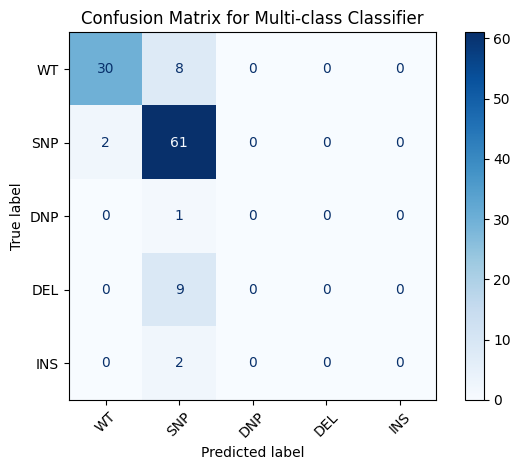

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for all five classes
cm = confusion_matrix(y_test_np, y_pred, labels=[0,1,2,3,4])

# Define the class names in the same order as their codes
class_names = ['WT', 'SNP', 'DNP', 'DEL', 'INS']

# Create and plot the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-class Classifier')
plt.tight_layout()
plt.show()